In [ ]:
from scipy.stats import ttest_rel
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/city_day.csv')
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() * 100 / len(df)
print('Missing Percentage:', missing_percentage)

# Median Imputation for Numerical Columns
numerical_cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

Missing Percentage: City           0.000000
Date           0.000000
PM2.5         15.570079
PM10          37.723071
NO            12.129626
NO2           12.139785
NOx           14.171549
NH3           34.973418
CO             6.972334
SO2           13.050692
O3            13.619586
Benzene       19.041008
Toluene       27.229014
Xylene        61.322001
AQI           15.851139
AQI_Bucket    15.851139
dtype: float64


In [ ]:
# Create a mapping based on existing data
aqi_bucket_mapping = {
    'Good': (0, 50),
    'Satisfactory': (51, 100),
    'Moderate': (101, 200),
    'Poor': (201, 300),
    'Very Poor': (301, 400),
    'Severe': (401, 500)
}
def map_aqi_to_bucket(aqi_value):
    for bucket, (lower, upper) in aqi_bucket_mapping.items():
        if lower <= aqi_value <= upper:
            return bucket
    return np.nan  # return NaN if the AQI value is out of known ranges

# Apply the mapping function to fill 'AQI_Bucket'
df['AQI_Bucket'].fillna(df['AQI'].apply(map_aqi_to_bucket), inplace=True)

In [ ]:
# Calculate the percentage of missing values for each column after cleaning
missing_percentage_after = df.isnull().sum() * 100 / len(df)
print('Missing Percentage After Cleaning:', missing_percentage_after)


Missing Percentage After Cleaning: City          0.0
Date          0.0
PM2.5         0.0
PM10          0.0
NO            0.0
NO2           0.0
NOx           0.0
NH3           0.0
CO            0.0
SO2           0.0
O3            0.0
Benzene       0.0
Toluene       0.0
Xylene        0.0
AQI           0.0
AQI_Bucket    0.0
dtype: float64


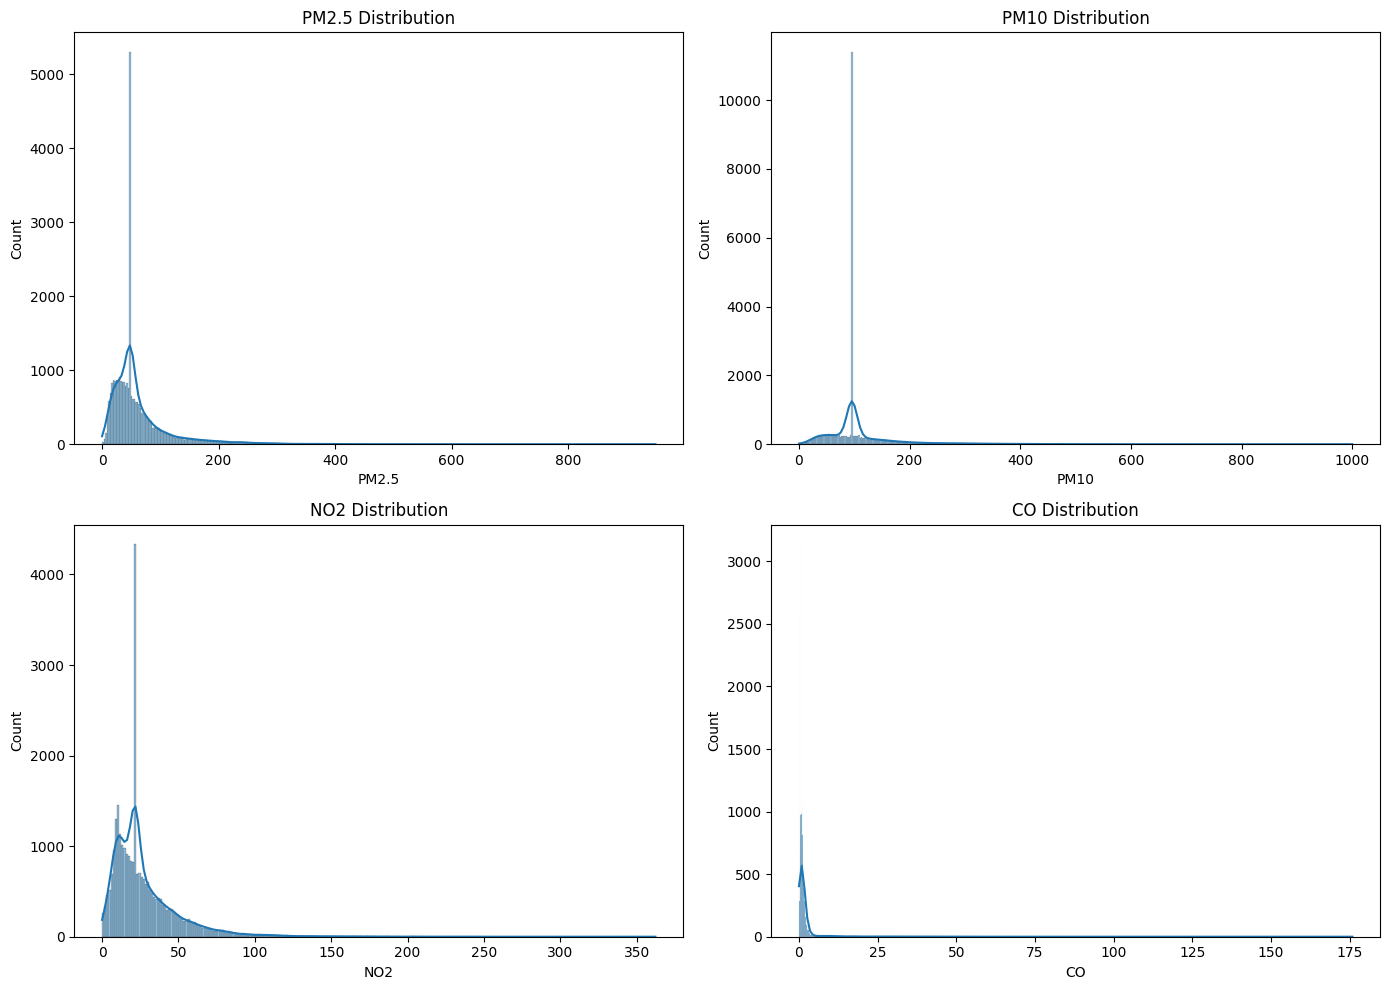

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(df['PM2.5'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('PM2.5 Distribution')
sns.histplot(df['PM10'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('PM10 Distribution')
sns.histplot(df['NO2'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('NO2 Distribution')
sns.histplot(df['CO'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('CO Distribution')
plt.tight_layout()
plt.show()

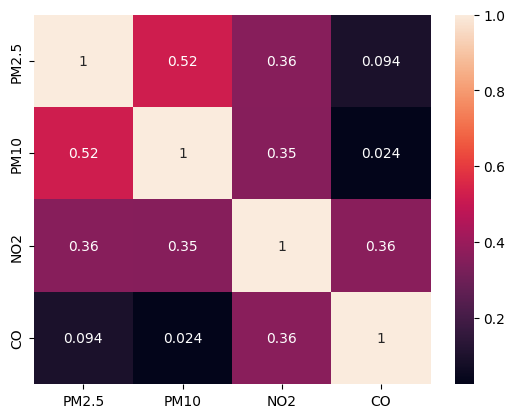

In [ ]:
correlation_matrix = df[['PM2.5', 'PM10', 'NO2', 'CO']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

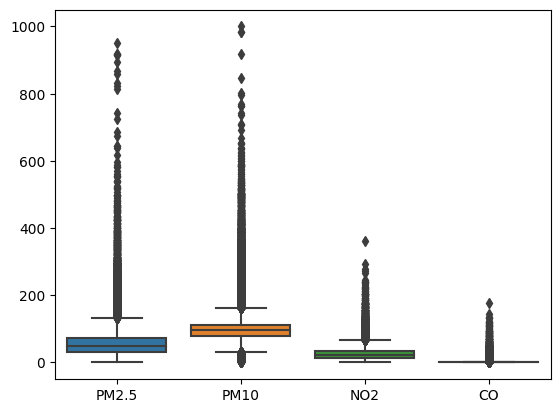

In [ ]:
sns.boxplot(data=df[['PM2.5', 'PM10', 'NO2', 'CO']])
plt.show()

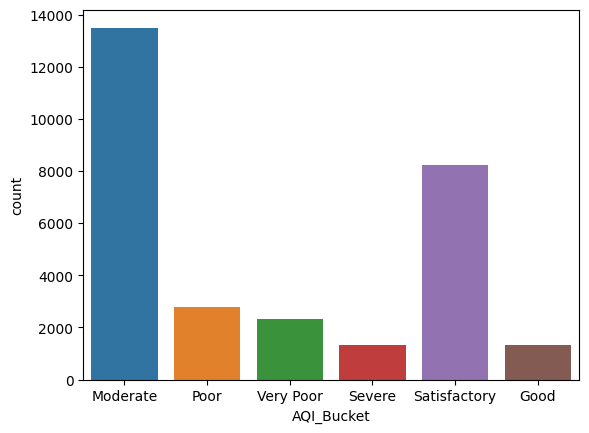

In [ ]:
sns.countplot(data=df, x='AQI_Bucket')
plt.show()

<Axes: >

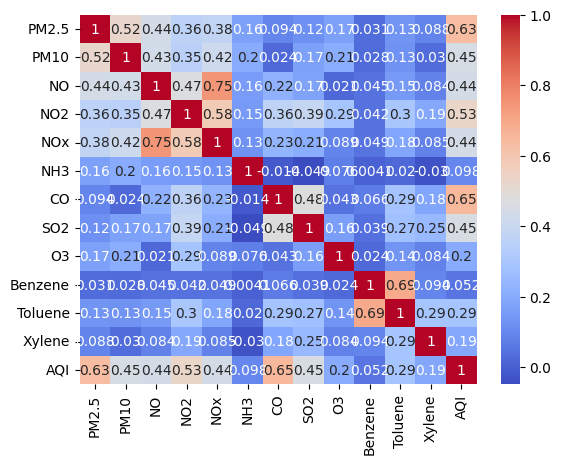

In [ ]:
# Create a heatmap to visualize the correlation between features and 'AQI_Bucket'
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')


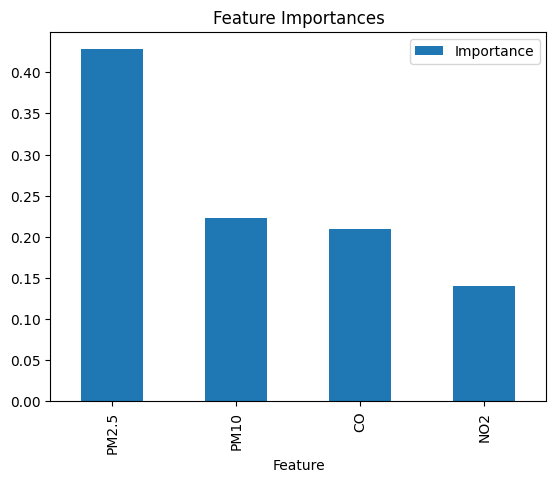

In [ ]:
# Function for calculating feature importances
def feature_importance(X_train, y_train):
    # Initialize the model
    rf = RandomForestClassifier()
    # Fit the model
    rf.fit(X_train, y_train)
    # Get feature importances
    importances = rf.feature_importances_
    # Create a DataFrame for visualization
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    # Sort and visualize
    feature_importances.sort_values(by='Importance', ascending=False).plot(kind='bar', x='Feature', y='Importance')
    plt.title("Feature Importances")
    plt.show()

# Prepare the features and target variable
X = df[['PM2.5', 'PM10', 'NO2', 'CO']]
y = df['AQI_Bucket']

# Data Splitting
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Splitting off the test set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # Splitting the remaining data into training and validation sets
feature_names = X.columns

# Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Call the feature importance function
feature_importance(X_train, y_train)

In [ ]:
# Function for hyperparameter tuning
def tune_hyperparameters(model, param_grid, X, y):
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X, y)
    return grid_search.best_params_

In [ ]:
# Function for model evaluation
def evaluate_model(model, X_val, y_val, X_test, y_test):
    y_pred_val = model.predict(X_val)
    print("Validation Results:")
    print(classification_report(y_val, y_pred_val))
    y_pred_test = model.predict(X_test)
    print("Test Results:")
    print(classification_report(y_test, y_pred_test))

In [ ]:
# Initialize models and their parameter grids
models_param_grid = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),  # max_iter set to 1000 here
    'RandomForestClassifier': (RandomForestClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]}),
    'SVC': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['auto', 'scale']})
}

# Identify all unique labels in target variable
unique_labels = y.unique().tolist()

# Placeholder for storing performance data
performance_data = []

# Placeholders for models T-test
final_model_lr = None
final_model_rf = None
final_model_svc = None

# Loop through models for training, tuning, and evaluation
for model_name, (model, param_grid) in models_param_grid.items():
    print(f"Training and evaluating {model_name}...")
    best_params = tune_hyperparameters(model, param_grid, X_train, y_train)

    # Train model with best parameters
    final_model = model.set_params(**best_params)
    final_model.fit(X_train, y_train)
    if model_name == 'LogisticRegression':
      final_model_lr = final_model
    elif model_name == 'RandomForestClassifier':
      final_model_rf = final_model
    elif model_name == 'SVC':
      final_model_svc = final_model


    # Evaluate model
    y_pred_val = final_model.predict(X_val)
    y_pred_test = final_model.predict(X_test)
    val_report = classification_report(y_val, y_pred_val, output_dict=True, labels=unique_labels, target_names=unique_labels)
    test_report = classification_report(y_test, y_pred_test, output_dict=True, labels=unique_labels, target_names=unique_labels)

    performance_data.append({
        'Model': model_name,
        'Best Hyperparameters': best_params,
        'Validation Accuracy': val_report['accuracy'],
        'Test Accuracy': test_report['accuracy']
    })

# Convert performance data to DataFrame
performance_df = pd.DataFrame(performance_data)
# print(performance_df)
# Adjust display settings to show more content
pd.set_option('display.max_colwidth', None)
# Highlight the highest accuracy in green for better visibility
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: limegreen' if v else '' for v in is_max]

performance_df.style.apply(highlight_max, subset=['Validation Accuracy', 'Test Accuracy'])

Training and evaluating LogisticRegression...
Training and evaluating RandomForestClassifier...
Training and evaluating SVC...


,Model,Best Hyperparameters,Validation Accuracy,Test Accuracy
0,LogisticRegression,{'C': 100},0.729597,0.737261
1,RandomForestClassifier,"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}",0.787843,0.797528
2,SVC,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.764985,0.774166


In [ ]:
# Benchmark model as a special case
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dummy)
print(f"Benchmark Model Accuracy: {accuracy}")


Benchmark Model Accuracy: 0.46775012696800405


In [ ]:
# Get predictions from each model on the validation set
y_pred_lr = final_model_lr.predict(X_val)
y_pred_rf = final_model_rf.predict(X_val)
y_pred_svc = final_model_svc.predict(X_val)

# Check the type of the first prediction
print(type(y_pred_lr[0]))

# If string then encode the predictions to numeric values
if isinstance(y_pred_lr[0], str):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(y)  # Fit on the original target variable to ensure consistent encoding
    y_pred_lr = le.transform(y_pred_lr)
    y_pred_rf = le.transform(y_pred_rf)
    y_pred_svc = le.transform(y_pred_svc)


# Perform t-tests
t_statistic, p_value = ttest_rel(y_pred_lr, y_pred_rf)
print(f"P-value between Logistic Regression and Random Forest: {p_value}")

t_statistic, p_value = ttest_rel(y_pred_lr, y_pred_svc)
print(f"P-value between Logistic Regression and SVC: {p_value}")

t_statistic, p_value = ttest_rel(y_pred_rf, y_pred_svc)
print(f"P-value between Random Forest and SVC: {p_value}")


<class 'str'>
P-value between Logistic Regression and Random Forest: 1.0648861469835213e-20
P-value between Logistic Regression and SVC: 2.04580124794152e-37
P-value between Random Forest and SVC: 0.8310861423794849
